# 

# Linear Algebra for Electrical Systems
## 2021-fall (430.216, Instructor: prof. Young Min Kim)
## TAs: Cheol-Hui Min and Junho Lee

## HW5: Classification via Least Squares
---

- In this homework, we will explore the applications of QR factorization and back substitution
we have implemented in the HW3 on the data science problems.

- You will be asked to formulate a simple least squares solver using 
methods we have implemented in HW3 `gram_schmidt`, `QR_factorization`, `back_subst`, and `solve_via_backsub`.
We provide those methods for your convenience.

- This HW consists of 3 problems.
    - Problem 1. Constructing a simple least squares solver.
    - Problem 2. Classification of IRIS flower dataset.
    - Problem 3. Multi-class classification of IRIS flower dataset.
 
- Please fill out all the `Problem #K. fill out here.` annotated parts.

- You should **NOT** use methods under `np.linalg` API. Please use generic `numpy` methods.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np

## Problem 1. Constructing a simple least squares solver via QR factorization
---
We follow the pseudo code in the pp. 232 of our textbook, to solve least squares
via QR factorization.



First, let's prepare some ingredients we have implemented in HW3.

In [ ]:
def norm(v):
    """
        Compute the 2-norm of given vector.
        Input:
            a batch of vector of shape [N, D] 
        Return:
            a batch of computed 2-norm of shape [N, D]
    """
    # Assume we use Frobenious norm (Euclidean norm)
    return np.sqrt(np.sum(v**2, axis=-1))


def gram_schmidt(a):
    """
    in: a - length k list of n-dim np.arrays.
    out: q - length k list of n-dim orthonormal np.arrays. 
    """
    q = []
    # orthogonalization
    for i in range(len(a)): # for i = 1, ..., k
        q_tilde = a[i]
        for j in range(len(q)): # for each dimension of q_tilde
            # recursively add dot(q)
            q_tilde = q_tilde - (np.dot(q[j], a[i]))*q[j]
        # Test for linear dependence. If \tilde{q}_i = 0.
        if np.sqrt(sum(q_tilde**2)) <= 1e-10:
            print('Vectors are linearly dependent.')
            print('GS algorithm terminates at iteration ', i+1)
            return q
        #Normalization
        else:
            q_tilde = q_tilde / norm(q_tilde)
            q.append(q_tilde)
    return q


def QR_factorization(A):
    """
    in: numpy array whose k columns are linearly independent.
    """
    # we feed gram_schmidt() A.T since it orthonormalizes row vectors of the input array. 
    # Thus, we get transposed array whose rows are orthonormal. 
    Q_transpose = np.array(gram_schmidt(A.T))
    R = Q_transpose @ A # since Q^T = Q^-1
    Q = Q_transpose.T
    return Q, R



# define the back-substitution function.
# please refer to pp.207 of our textbook.
def back_subst(R, b_tilde):
    n = R.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)): # iterate in reversed order: n, n-1, ..., 1.
        x[i] = b_tilde[i]
        for j in range(i+1, n):
            x[i] = x[i] - R[i,j] * x[j]
        x[i] = x[i]/R[i,i]
    return x


# define a solver the uses back_substituion.
def solve_via_backsub(A, b):
    # first to QR factorization
    Q, R = QR_factorization(A)

    # let b_tilde as Q^T b
    b_tilde = Q.T @ b

    # solve Rx=Q^Tb to get x.
    x = back_subst(R, b_tilde)
    return x

<!-- If we choose $\mathbf{\tilde{q}}_1= \mathbf{a}_1$, then the orthogonal component of projection of $\mathbf{a}_2$ onto $\mathbf{\tilde{q}}_1$ is $\mathbf{\tilde{q}}_2$.


Define the projecttion of vector $\mathbf{a}_2$ on the vector $\mathbf{\tilde{q}}_1$ as $\text{Proj}_{\mathbf{\tilde{q}}_1}\mathbf{a}_2 = \alpha \mathbf{a}_1$, 

 then $(\mathbf{a}_2 - \alpha \mathbf{a}_1)\cdot \mathbf{a}_1 = 0$, rearange for $\alpha$

$$
\alpha = \frac{\mathbf{a}_2^T\mathbf{a}_1}{\mathbf{a}_1^T\mathbf{a}_1}
$$

According to definition above

$$
\text{Proj}_{\mathbf{\tilde{q}}_1}\mathbf{a}_2 = \alpha \mathbf{a}_1 = \frac{\mathbf{a}_2^T\mathbf{a}_1}{\mathbf{a}_1^T\mathbf{a}_1}\mathbf{a}_1
$$

The orthogonal component, $\mathbf{\tilde{q}}_2$ is 

$$
\mathbf{a}_2- \text{Proj}_{\mathbf{\tilde{q}}_1}\mathbf{a}_2 =\mathbf{a}_2 - \frac{\mathbf{a}_2^T\mathbf{a}_1}{\mathbf{a}_1^T\mathbf{a}_1}\mathbf{a}_1
$$ -->

### First solve toy example with numpy's innate methods. 

In [ ]:
# define a matrix having linearly independent columns.
A = np.array([[2, 0], [-1, 1], [0, 2]])
b = np.array([1, 0, -1])

In Eq.(12.5) and Eq.(12.6)of our textbook, we find that

$\mathbf{\hat{x}}=(A^{\top}A)^{-1}A^{\top}\mathbf{b}=A^{\dagger}\mathbf{b}$

yields the solution for least squares problem.


In [ ]:
# solve using the second term. use numpy.linalg.inv
sol1 = np.linalg.inv(A.T @ A) @ A.T @ b
print(sol1)

# solve using the pinv solver of numpy.
sol2 = np.linalg.pinv(A)@ b
print(sol2)

x_hat = sol2
# check of Eq.(12.4) holds.
np.allclose((A.T @ A) @ x_hat, A.T @ b)

[ 0.33333333 -0.33333333]
[ 0.33333333 -0.33333333]


True

### Now we solve the approximate solution of least squares problem via QR factorization, referring to Algorithm 12.1.

In [ ]:
A = np.random.normal(size = (100, 20))
b = np.random.normal(size = 100)

# solve via our custom solver.
Q, R = QR_factorization(A)
x1 = np.linalg.inv(R) @ Q.T @ b # QR factorization 사용
x2 = np.linalg.inv(A.T @ A) @ (A.T @ b)
x3 = np.linalg.pinv(A) @ b

print(np.allclose(x1, x2))
print(np.allclose(x1, x3))


True
True


### Now we solve the lamp illumination problem.

In [ ]:
# number of lamps
n = 10
# x, y positions of lamps and height above floor 
lamps = np.array([
        [4.1, 20.4, 4], [14.1, 21.3, 3.5], [22.6, 17.1, 6],
        [5.5, 12.3, 4.0], [12.2, 9.7, 4.0], [15.3, 13.8, 6],
        [21.3, 10.5, 5.5], [3.9 ,3.3, 5.0], [13.1, 4.3, 5.0],
        [20.3, 4.2, 4.5]
    ])
N = 25 # grid size
m = N * N # number of pixels
# construct m x 2 matrix with coordinates of pixel centers

# print(np.outer(np.arange(0.5, N, 1),
#                             np.ones(N)).shape)


# assume we have 25 X 25 gridmap, where (0, 0) is the coordinate of top left corner 
# and (25, 25) is the coordinate of bottom right corner.
# the center of each grid should have tho coordinate like
# [(0.5, 0.5), (1.5, 0.5), (2.5, 0.5) ... (24.5, 0.5)]
# [(0.5, 1.5), (1.5, 1.5), (2.5, 1.5)  ...(24.5, 1.5)]
#                          ...
# [(0.5, 24.5),            ...           (24.5, 24.5)]

# define [625, 2] shaped array containing pixel coordinates.

# first create equally spaced values in [0.5, 24.5], into 25 values.
spaces = np.linspace(0.5, 24.5, num = 25)

# now we create value mesh for each horizontal (x) and vertical (y) axis
mesh_x, mesh_y = np.meshgrid(spaces, spaces)

# create a mesh that each node containing the center coordinate and the zero
mesh = np.stack([mesh_x, mesh_y, np.zeros((25, 25))], axis=-1)

# reshape for the computation convenience
mesh = mesh.reshape(-1, 3)

# The m x n matrix A maps lamp powers to pixel intensities. 
# A[i,j] is inversely proportional to the squared distance of
# lamp j to pixel i.
A = np.zeros((m, n)) # intensity matrix for m grids and n lamps.T

for i in range(m): # iterate over m grids.
    for j in range(n): # iterate over n lamps.
        A[i, j] = 1/(norm(mesh[i] - lamps[j]))**2 # intensity ~ inverse of distance
print(A.shape)

A = (m/np.sum(A)) * A # scale elements of A

# solve least squares equation.
x = np.linalg.pinv(A) @ np.ones((625, 1))

# compute rms error.
rms_ls = (sum((A @ x - 1)**2)/m)**0.5
print(rms_ls)


(625, 10)
[0.14039048]


Let's visualize the histogram for intensity for each pixel.

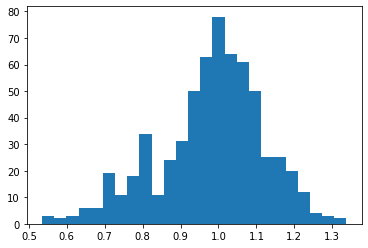

In [ ]:
plt.hist(A @ x, bins = 25)
plt.show()

## Problem 2. Classification of IRIS flower dataset.

Now we conduct the classification problem using IRIS dataset.
First, let's prepare the IRIS flower dataset.

In addition we take the least squares classifier based on the regression model,
as shown in pp.289 of our textbook.

In [ ]:
! pip install sklearn
import sklearn
from sklearn.datasets import load_iris
iris = load_iris()

X = iris['data'] # (150, 4)
# first 50 rows are for 'setosa', next 50 rows are 'versicolor', and the last 50 are 'virginica'

# we simplify the problem as binary classification. y is 1 for 'virginical' and -1 otherwise.
y = 2 * np.concatenate([np.zeros(100), np.ones(50)]) - 1. # (150,)

# we add the offset 'v' as all ones-array to create regression model.

A = np.concatenate([np.ones((150, 1)), X], axis=-1) # [150, 5]

# find regression model parameter thetas

theta = np.linalg.pinv(A) @ y # [5,]

# show the predictions. Check if the prediction is True (>0) or False (<=0).
results = (A @ theta) > 0
print(results)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False False False False False  True False False False  True False
 False False False False False  True False False False False False False
  True  True False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True False  True  True
  True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


## Problem 3. Multi-class classification of IRIS dataset.
Now, we will conduct multi-class classification of the IRIS dataset.

As shown in the textbook, the $K$-class classifier can be expressed as 

$
\hat{f}({\mathbf{x}})=\argmax_k \tilde{f}_k(\mathbf{x}).
$

We can simplify this as matrix-vector notation as

$
\hat{f}({\mathbf{x}})=\argmax \mathbf{x}^{\top}\Theta,
$

where $\Theta=[\theta_1, \cdots, \theta_K] \in \mathbb{R}^{n \times K}$.


In [ ]:

# we define row argmax function, that returns the index for the maximum value along each row.
# Thus, for K columns and N samples, we can find the maximum values among K class predictions.
# we use python's Lambda function for convenience. 
# please refer to this: https://stackabuse.com/lambda-functions-in-python/

# iterate for each row by index i, and find the maximum value for among columns.
row_argmax = lambda u: [ np.argmax(u[i]) for i in range(len(u))]

# test our lambda function.
A = np.random.normal(size = (4, 5))
print(A)
print(row_argmax(A))

[[-0.70954197  3.04564803 -0.50479895  0.87804758  0.17338234]
 [ 0.42331139  1.27055367 -0.15251485  1.05670119  0.33340286]
 [-0.53197877  0.48467824  0.02402072  0.32268442  1.22189543]
 [-0.36430373 -0.86995265  0.63712168 -1.47172834  0.16037026]]
[1, 1, 4, 2]


In [ ]:
# we also define a one-hot function that changes the label into one-hot vector.
# please refer to this for more information about one-hot vector.
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
# ycl이 정수 label들이 들어있는 것으로 생각해야 한다. 

def one_hot(ycl, K):

    N = len(ycl) # get the amount of labels.
    Y = np.zeros((N, K)) # dummy matrix.
    for j in range(K): # iterate over K classes
        for i in range(N):
          if (ycl[i] == j):
            Y[i][j] = 1  # set element to 1 if class index is equal to index j.
    return Y

In [ ]:
# multi-class least-squares solver
def ls_multiclass(X, ycl, K):
    """
        X: training data # [6, 120]
        ycl: class labels. # [120, ]
        K: number of .# 3
    """
    # get one_hot labels.
    one_hot_label = one_hot(ycl, K)

    # change into singed labels.
    signed_label = 2*one_hot_label - np.ones((len(ycl), K)) #[N*K]

    # solve matrix form least squares
    theta_cols = []
    for i in range(K): # iterate over K columns
        theta = np.linalg.pinv(X.T) @ signed_label[:, i] # solve least squares
        theta_cols.append(theta)
    Theta = np.array(theta_cols) # get theta matrix [N*K]

    # get prediction
    yhat = np.array(row_argmax(X.T @ Theta.T))
    return Theta, yhat

In [ ]:
# shuffle dataset for each class. Use this indices to create train/test split.
I1 = np.random.permutation(50) # 0부터 49까지의 수가 들어있는 배열
I2 = np.random.permutation(50) + 50
I3 = np.random.permutation(50) + 100

# training set consists of 40 randomly picked examples per class
Xtrain = np.vstack(
    [
      # random.sample은 배열에서 값을 임의로 추출하는 함수
      np.hstack([I1[10:50], I2[10:50], I3[10:50]]),
      np.hstack([I1[0:10], I1[20:50], I2[0:10], I2[20:50], I3[0:10], I3[20:50]]),
      np.hstack([I1[0:20], I1[30:50], I2[0:20], I2[30:50], I3[0:20], I3[30:50]]),
      np.hstack([I1[0:30], I1[40:50], I2[0:30], I2[40:50], I3[0:30], I3[40:50]]),
      np.hstack([I1[0:40], I2[0:40], I3[0:40]])
     ]) # [5, 120]

# add contant feature one
Xtrain = np.vstack([np.ones(120), Xtrain]) # [6, 120]

# the true labels for train set are a sequence of 0s, 1s and 2s
# since the examples in Xtrain are stacked in order
ytrain = np.hstack([np.zeros(40), np.ones(40), 2 * np.ones(40)]) # [120, ]

# test set is remaining 10 examples for each class Xtest
Xtest = np.vstack(
    [
    np.hstack([I1[0:10], I2[0:10], I3[0:10]]),
    np.hstack([I1[10:20], I2[10:20], I3[10:20]]),
    np.hstack([I1[20:30], I2[20:30], I3[20:30]]),
    np.hstack([I1[30:40], I2[30:40], I3[30:40]]),
    np.hstack([I1[40:50], I2[40:50], I3[40:50]]),
    ])

Xtest = np.vstack([np.ones(30), Xtest]) # [6, 30]
ytest = np.hstack([np.zeros(10), np.ones(10), 2 * np.ones(10)]) # [30, ]

# get the Theta matrix
Theta, yhat = ls_multiclass(Xtrain, ytrain, 3)

# compute rms error for training set
rms_train = (sum((yhat - ytrain)**2)/ 120)**0.5

print(rms_train)

# check for the test set
y_hat_test = row_argmax(Xtest.T @ Theta.T)
#print(Xtest.T@Theta.T)
rms_test = (sum((y_hat_test - ytest)**2)/ 30)**0.5

print(rms_test)

0.48304589153964794
0.5477225575051661
